# Your Best Choice of Airbnb in Seattle
### I am planning a trip to Seattle for 3 days and want to book a nice place from Airbnb with a reasonable price. Here is how I make my choice using Airbnb data retrieved online *(http://insideairbnb.com/get-the-data.html)*. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you can't import folium
import folium # map rendering library
%matplotlib inline

### Load data 

In [2]:
# downLoad online data file
!wget -O listings.csv http://data.insideairbnb.com/united-states/wa/seattle/2020-04-23/visualisations/listings.csv
!wget -O reviews.csv.gz http://data.insideairbnb.com/united-states/wa/seattle/2020-04-23/data/reviews.csv.gz    

--2020-06-07 19:00:38--  http://data.insideairbnb.com/united-states/wa/seattle/2020-04-23/visualisations/listings.csv
Resolving data.insideairbnb.com (data.insideairbnb.com)... 52.216.88.50
Connecting to data.insideairbnb.com (data.insideairbnb.com)|52.216.88.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1127379 (1.1M) [application/csv]
Saving to: ‘listings.csv’

listings.csv        100%[===================>]   1.07M  5.14MB/s    in 0.2s    

2020-06-07 19:00:39 (5.14 MB/s) - ‘listings.csv’ saved [1127379/1127379]

--2020-06-07 19:00:39--  http://data.insideairbnb.com/united-states/wa/seattle/2020-04-23/data/reviews.csv.gz
Resolving data.insideairbnb.com (data.insideairbnb.com)... 52.216.88.50
Connecting to data.insideairbnb.com (data.insideairbnb.com)|52.216.88.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 43997555 (42M) [application/x-gzip]
Saving to: ‘reviews.csv.gz’

reviews.csv.gz      100%[===================>]  41.96M  

In [3]:
# Load listing data into dataframe
list = pd.read_csv('./listings.csv')
print('Shape of data set "list" is: ', list.shape)
list.head()

Shape of data set "list" is:  (7237, 16)


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2318,Casa Madrona - Urban Oasis 1 block from the park!,2536,Megan,Central Area,Madrona,47.61082,-122.29082,Entire home/apt,296,7,32,2020-02-01,0.23,2,90
1,6606,"Fab, private seattle urban cottage!",14942,Joyce,Other neighborhoods,Wallingford,47.65411,-122.33761,Entire home/apt,90,30,150,2019-09-28,1.14,3,82
2,9419,Glorious sun room w/ memory foambed,30559,Angielena,Other neighborhoods,Georgetown,47.55017,-122.31937,Private room,62,2,148,2019-12-27,1.25,8,364
3,9531,The Adorable Sweet Orange Craftsman,31481,Cassie,West Seattle,Fairmount Park,47.55539,-122.38474,Entire home/apt,165,3,40,2019-12-30,0.40,2,365
4,9534,The Coolest Tangerine Dream MIL!,31481,Cassie,West Seattle,Fairmount Park,47.55624,-122.38598,Entire home/apt,125,2,49,2020-02-29,0.49,2,350


#### Clean "listings" data

In [4]:
# Check list columns and data types
list.dtypes

id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object

In [5]:
# Check if column "id" is unique with no repeatation
list.shape[0]==list['id'].unique().shape[0]

True

In [6]:
# Check the pertentage of NaN numbers in the data set
np.sum(list.isna())/list.shape[0]

id                                0.00000
name                              0.00000
host_id                           0.00000
host_name                         0.00000
neighbourhood_group               0.00000
neighbourhood                     0.00000
latitude                          0.00000
longitude                         0.00000
room_type                         0.00000
price                             0.00000
minimum_nights                    0.00000
number_of_reviews                 0.00000
last_review                       0.12823
reviews_per_month                 0.12823
calculated_host_listings_count    0.00000
availability_365                  0.00000
dtype: float64

##### Only 13% of rental listing has no data in "last_review" and "reviews_per_month".

In [7]:
# Check the descriptive statistics of the dataset
col_num=list.select_dtypes(include='number').columns
list[col_num].describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,7.237000e+03,7.237000e+03,7237.000000,7237.000000,7237.000000,7237.000000,7237.000000,6309.000000,7237.000000,7237.000000
mean,2.271403e+07,6.633280e+07,47.625198,-122.333424,159.286859,12.926351,55.016858,2.006721,31.239878,148.942241
std,1.226501e+07,7.997071e+07,0.046540,0.032263,276.241988,22.390226,81.536585,1.971421,76.386140,132.518608
min,2.318000e+03,2.536000e+03,47.495870,-122.419250,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,1.308409e+07,8.534462e+06,47.603460,-122.354350,79.000000,2.000000,3.000000,0.430000,1.000000,6.000000
50%,2.221067e+07,3.242663e+07,47.620820,-122.332350,115.000000,2.000000,20.000000,1.360000,2.000000,122.000000
75%,3.406395e+07,8.903879e+07,47.660740,-122.311190,180.000000,30.000000,75.000000,3.060000,8.000000,277.000000
max,4.325888e+07,3.421319e+08,47.734030,-122.240950,10000.000000,1000.000000,836.000000,18.410000,312.000000,365.000000


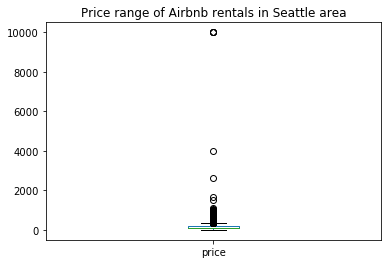

In [8]:
# Check the statistics of price
list['price'].plot(kind='box')
plt.title("Price range of Airbnb rentals in Seattle area");

##### Rental price does have some outliers which are larger than 500 dollars although the median price is just 115 dollars.

In [9]:
# Check the pertentage of outliers
sum(list['price']>500)/list.shape[0]

0.024872184606881304

##### Only 2.5% of listings have price higher than 500 dollars. Let's exclude those data and plot again. 

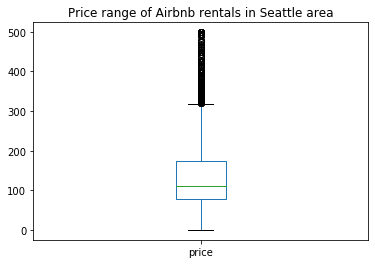

In [10]:
list.loc[list['price']<500,'price'].plot(kind='box')
plt.title("Price range of Airbnb rentals in Seattle area");

I will drop those data with NaN in reviews since I only want to investigate with rental listings with reviews. I will also drop data with price higher than 500 dollars since I am not interested in those expensive rentals and these outliers only consist a very small portion of data. 

In [11]:
list.dropna(how='any',inplace=True)
list.drop(list[list['price']>500].index,inplace=True)

In [12]:
print('Shape of cleaned data set "list" is: ', list.shape)

Shape of cleaned data set "list" is:  (6170, 16)


Let's convert "room_type" to number for better understanding of the data

In [13]:
list['room_type'].unique()

array(['Entire home/apt', 'Private room', 'Shared room', 'Hotel room'],
      dtype=object)

In [14]:
# Encode "room_type" to number as the mapping in "cats"
ordered_room_type = ['Shared room', 'Private room', 'Hotel room', 'Entire home/apt']
cat_dtype = pd.api.types.CategoricalDtype(categories=ordered_room_type, ordered=True)
list['room_type_cat'] = list['room_type'].astype(cat_dtype).cat.codes
list.head(3)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,room_type_cat
0,2318,Casa Madrona - Urban Oasis 1 block from the park!,2536,Megan,Central Area,Madrona,47.61082,-122.29082,Entire home/apt,296,7,32,2020-02-01,0.23,2,90,3
1,6606,"Fab, private seattle urban cottage!",14942,Joyce,Other neighborhoods,Wallingford,47.65411,-122.33761,Entire home/apt,90,30,150,2019-09-28,1.14,3,82,3
2,9419,Glorious sun room w/ memory foambed,30559,Angielena,Other neighborhoods,Georgetown,47.55017,-122.31937,Private room,62,2,148,2019-12-27,1.25,8,364,1


### Q1: Is there an area in Seattle where there are more choices of rentals with relatively lower price? 
##### Now let's look at the number of listings and mean price in each neighbourhood

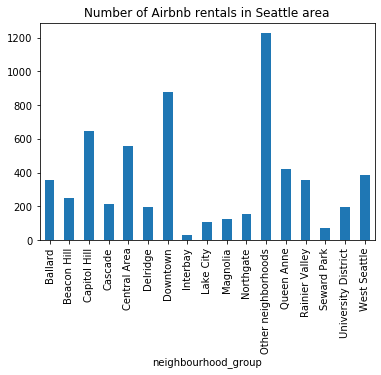

In [15]:
# get the number of listing in each neighbourhood
num_list = list[['id','neighbourhood_group']].groupby('neighbourhood_group').count() 
num_list['id'].plot(kind="bar");
plt.title("Number of Airbnb rentals in Seattle area");

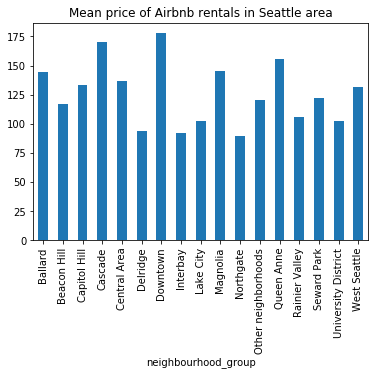

In [16]:
# get the number of listing in each neighbourhood
price_mean = list[['price','neighbourhood_group']].groupby('neighbourhood_group').mean()
price_mean['price'].plot(kind="bar");
plt.title("Mean price of Airbnb rentals in Seattle area");

##### The most expensive Airbnb rentals are downtown area. Downtown area also has the second most number of rentals, only less that "other neighbourhoods" which actually is the collection of unsorted data.
##### Let's plot the above two figures togeter with sorted price from high to low.

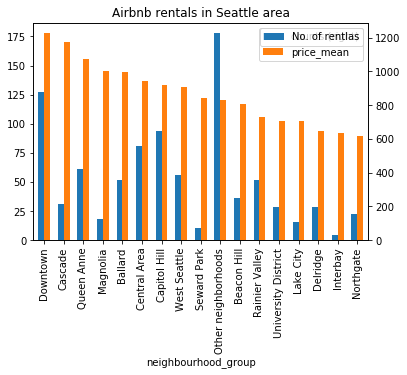

In [17]:
# Sort data by number of lisitng in each area and plot together with mean_price
df_area=num_list
df_area['price_mean']=price_mean['price']
df_area.rename(columns={"id": "counts"},inplace=True)
df_area.sort_values(by='price_mean',ascending=False,inplace=True)
df_area[['counts','price_mean']].plot(kind="bar",secondary_y= 'counts',width=0.6);
plt.title("Airbnb rentals in Seattle area");
plt.legend(['No. of rentlas','mean price']);

#### Capitol Hill seems to be a good area with more rentals and mean price less than $150.

### Q2: Can I predict the price of Seattle Airbnb rentals?

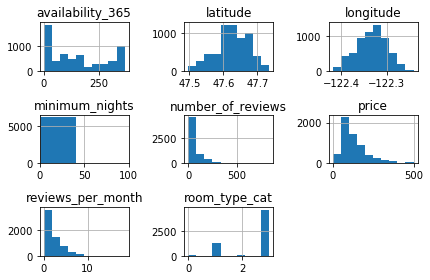

In [18]:
# Let's look at some statistical plots for df
features=['price','longitude','latitude','minimum_nights','number_of_reviews','availability_365','reviews_per_month','room_type_cat']
ax=list[features].hist(bins=10);
ax[1,0].set_xlim((0,100));
#ax[2,0].set_xlim((0,3));
plt.tight_layout()

(8.0, 0.0)

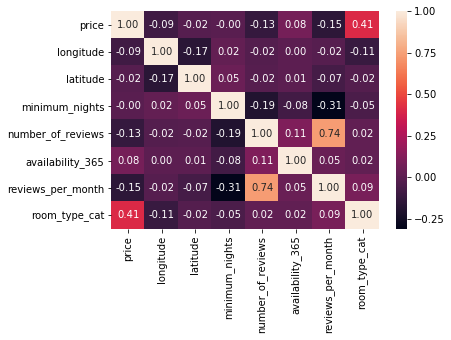

In [19]:
list_numeric=list[features]
ax=sns.heatmap(list_numeric.corr(), annot=True, fmt=".2f");
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

##### "review_per_month" and "number of reviews" are stongly correlated. Price seems only related to minimum_nights, but not strongly linear.

##### Let's see if we can predict price using other numerical features in the list using ridge regression model. I will drop "number of reviews" since it correlates with "number of reviews"

#### Regression model

##### Let me use the ridge regression model since I don't see any linear relationship between price and the above features.

In [20]:
# Define ridge regression model
def fit_ridge_mod(df, response_col, cat_cols, test_size=.3, rand_state=42):
    '''
    INPUT:
    df - a dataframe holding all the variables of interest
    response_col - a string holding the name of the column being predicted
    cat_cols - list of strings that are associated with names of the columns used for predicting
    test_size - a float between [0,1] about what proportion of data should be in the test dataset
    rand_state - an int that is provided as the random state for splitting the data into training and test 
    
    OUTPUT:
    test_score_out - float - r2 score on the test data
    train_score_out - float - r2 score on the test data
    rm_model_out - model object from sklearn
    X_train_out, X_test_out, y_train_out, y_test_out - output from sklearn train test split used for optimal model
    y_train_preds_out, y_test_preds_out: Predicted value for training set and test set from optimal model
    
    '''
    
    # 1. Split into explanatory and response variables
    X = df[cat_cols]
    y = df[response_col]

    # 2. Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=rand_state)
    
    # Test different alpha in regression model
    ref_score=-100
    
    for Alpha in [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]:
    
        # 3. Instantiate
        rm_model=Ridge(alpha=Alpha)
    
        # 4. Fit
        rm_model.fit(X_train, y_train) #Fit
            
        # 5. Predict and score the model
        y_train_preds = rm_model.predict(X_train)
        y_test_preds = rm_model.predict(X_test)
    
        # 6. Obtain an rsquared value 
        test_score=r2_score(y_test, y_test_preds)
        train_score=r2_score(y_train, y_train_preds)
        
        if test_score > ref_score: 
            ref_score = test_score
            test_score_out = test_score
            train_score_out = train_score
            rm_model_out = rm_model
            X_train_out = X_train
            X_test_out = X_test
            y_train_out = y_train
            y_test_out = y_test
            y_train_preds_out = y_train_preds
            y_test_preds_out = y_test_preds
        
    return test_score_out, train_score_out, rm_model_out, X_train_out, X_test_out, y_train_out, \
        y_test_out, y_train_preds_out, y_test_preds_out

In [21]:
# Define plotting function

def DistributionPlot(RedFunction, BlueFunction, RedName, BlueName, Title):
    width = 8
    height = 5
    plt.figure(figsize=(width, height))

    ax1 = sns.distplot(RedFunction, hist=False, color="r", label=RedName)
    ax2 = sns.distplot(BlueFunction, hist=False, color="b", label=BlueName, ax=ax1)

    plt.title(Title)
    plt.xlabel('Price (in dollars)')
    plt.ylabel('Proportion of listings')

    plt.show()
    plt.close()

In [22]:
#Test linear fitting model with 3 features below
cat_cols=['latitude','longitude','room_type_cat']
test_score, train_score, rm_model, X_train, X_test, y_train, y_test, y_train_preds, y_test_preds = fit_ridge_mod(list, 'price', cat_cols)
#Print training and testing score and regression model
print("The rsquared on the training data was {}.  The rsquared on the test data was {}.".format(train_score, test_score))
print("rm_model is: ", rm_model)

The rsquared on the training data was 0.16435296171028235.  The rsquared on the test data was 0.17630043498821746.
rm_model is:  Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)


In [23]:
#Test linear fitting model with another 3 features below
cat_cols=['minimum_nights','reviews_per_month','room_type_cat']
test_score, train_score, rm_model, X_train, X_test, y_train, y_test, y_train_preds, y_test_preds = fit_ridge_mod(list, 'price', cat_cols)
#Print training and testing score and regression model
print("The rsquared on the training data was {}.  The rsquared on the test data was {}.".format(train_score, test_score))
print("rm_model is: ", rm_model)

The rsquared on the training data was 0.19926509815763926.  The rsquared on the test data was 0.2175382874156615.
rm_model is:  Ridge(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)


In [24]:
#Test linear fitting model with 6 features below
cat_cols=['latitude','longitude','minimum_nights','availability_365','reviews_per_month','room_type_cat']
test_score, train_score, rm_model, X_train, X_test, y_train, y_test, y_train_preds, y_test_preds = fit_ridge_mod(list, 'price', cat_cols)
#Print training and testing score and regression model
print("The rsquared on the training data was {}.  The rsquared on the test data was {}.".format(train_score, test_score))
print("rm_model is: ", rm_model)

The rsquared on the training data was 0.2106077420300403.  The rsquared on the test data was 0.22120997205205573.
rm_model is:  Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)


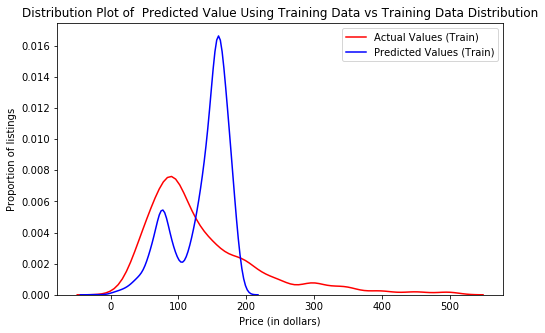

In [25]:
Title = 'Distribution Plot of  Predicted Value Using Training Data vs Training Data Distribution'
DistributionPlot(y_train, y_train_preds, "Actual Values (Train)", "Predicted Values (Train)", Title)

#### Using ridge regression model, the highest R2 score I got is 0.2. From the distribution plot, I can see that the predicted price doesn't match with the distribution of actual price between 100 and 200 dollars. 
#### It is difficult to predict the price by regression model using those available features in the "list" dataset. I may need more information about the rental such as squared feet, number of bedrooms, number of bathrooms and ect.

### Q3: Which Seattle area have most rentals with good reviews in recent two years?

#### Load and clean "reviews" data

In [26]:
# Load review data into dataframe
review = pd.read_csv('reviews.csv.gz', compression='gzip', header=0, sep=',', quotechar='"')
review.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,2318,146,2008-09-15,2451,Kevin,1000 times better than staying at a hotel.
1,2318,126302712,2017-01-10,12332845,Jessica,"Our family (two couples, a two year old and an..."
2,2318,140977084,2017-04-01,4789466,Ivan,Top of the list locations we have stayed at! T...
3,2318,147262504,2017-04-25,55817131,Mike,"SUCH an awesome place. Very clean, quiet and s..."
4,2318,161806368,2017-06-18,113604590,Pete,We flew quite a distance to be at our only dau...


In [27]:
# Check the pertentage of NaN numbers in the data set
np.sum(review.isna())/review.shape[0]

listing_id       0.000000
id               0.000000
date             0.000000
reviewer_id      0.000000
reviewer_name    0.000000
comments         0.000455
dtype: float64

In [28]:
# drop rows without comments
review.dropna(inplace=True)
review.shape

(397976, 6)

##### I pick some keywords to identify good review as the list "keywords" below.

In [29]:
# Get the review list which only containing good reviews in 2018~2020
keywords='good|better|best|excellent|perfect|wonderful|unique|great|awesome|nice|pretty|stylish|cute|fabulous \
|spacious|comfortable|comfy|convenient|top|clean|love|like|thank|Thank|appreciat|recommend|friendly|helpful'
years='2018|2019|2020'
review_good=review.loc[(review['comments'].str.contains(keywords) & review['date'].str.contains(years)),['listing_id','id','date']]
review_good.shape

(212962, 3)

In [30]:
# Calculate the pertentage of good review among all reviews
review_good.shape[0]/review.shape[0]

0.5351126701107605

##### Half of the reviews are good reviews. That sounds promising.

### merge two tables: list and review

In [31]:
# Now I'll merge two data sets review_good and list by id
rental_good=pd.merge(left=review_good['listing_id'], right=list['id'], left_on='listing_id', right_on='id')
# Sort the dataset by counts of good reviews
rental_good=rental_good.groupby('listing_id').count().reset_index()
rental_good.rename(columns={'id':'good_review_counts'},inplace=True)
rental_good.sort_values(by='good_review_counts',ascending=False,inplace=True)
print('There are ', rental_good.shape[0], 'rental listings that have good reveiws')
rental_good.head()

There are  5556 rental listings that have good reveiws


,listing_id,good_review_counts
1184,11398085,375
1298,12609601,333
451,3861673,299
656,6078397,298
596,5241773,268


##### The highest count of good reviews is 375 in recen two years.

In [32]:
# Add more information from list to the dataset
features=['id','name','price','neighbourhood_group','neighbourhood','latitude','longitude','room_type','room_type_cat', \
                   'minimum_nights','number_of_reviews','last_review','reviews_per_month', \
                   'calculated_host_listings_count','availability_365']
rental_good=pd.merge(left=rental_good, right=list[features], left_on='listing_id', right_on='id')
rental_good.drop(columns='id',inplace=True)
rental_good.head(3)

,listing_id,good_review_counts,name,price,neighbourhood_group,neighbourhood,latitude,longitude,room_type,room_type_cat,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,11398085,375,Cottage in the Heart of the City,89,Interbay,Interbay,47.63742,-122.38680,Entire home/apt,3,1,709,2020-03-19,14.66,1,188
1,12609601,333,Cozy basement suite with large patio & HOT TUB,100,Northgate,Maple Leaf,47.69537,-122.31758,Entire home/apt,3,1,421,2020-03-21,13.52,1,81
2,3861673,299,Beautiful Guest Suite for 2 in Ballard,70,Ballard,Whittier Heights,47.68403,-122.37409,Entire home/apt,3,7,836,2020-03-14,12.14,1,249


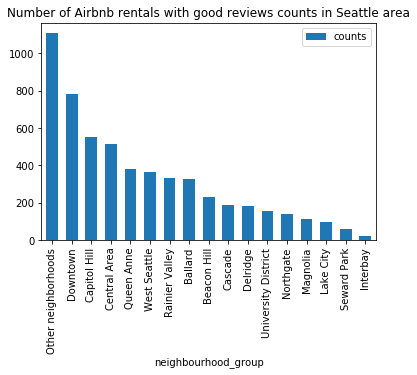

In [33]:
countByNei=rental_good[['listing_id','neighbourhood_group']].groupby('neighbourhood_group').count()
countByNei.rename(columns={'listing_id':'counts'},inplace=True)
countByNei.sort_values(by='counts',ascending=False, inplace=True)
ax=countByNei.plot(kind="bar",width=0.6);
ax.set_title("Number of Airbnb rentals with good reviews counts in Seattle area");

#### Besides "other neighborhoods", downtown area has the most number of good rentals, followed by capitol hill and central area.

### Q4. Which Airbnb is recommended in downtown Seattle?

##### I still want to stay in Seattle downtow although price is a bit higher. I will choose the rentals with more number of good review and relatively lower price. And it must have the following features:
- in downtown area
- hotel room or entire home/apartment
- minimum_nights < 4
- availability_365 > 180
- price < $350

In [34]:
features=['listing_id','name','good_review_counts','neighbourhood_group','price',
          'neighbourhood','latitude','longitude','room_type','minimum_nights']
rental_downtown=rental_good.loc[((rental_good['neighbourhood_group']=='Downtown') &
                             (rental_good['room_type_cat']>2) &
                             (rental_good['minimum_nights']<4) &
                             (rental_good['availability_365']>180) &
                             (rental_good['price']<350)) 
                                ,features]
rental_downtown.shape[0]

228

##### There are 228 rentals meets my criterias. Let me pick top 10 with most good reviews

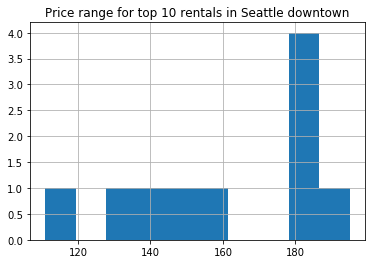

In [35]:
# Sort downtown rental by number of good reviews
rental_downtown.sort_values(by='good_review_counts',ascending=False,inplace=True)
# check the price range of top 20rental_downtown
ax=rental_downtown['price'].iloc[0:10].hist();
ax.set_title("Price range for top 10 rentals in Seattle downtown");

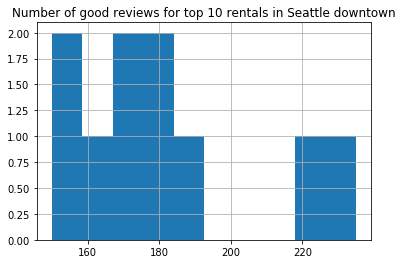

In [36]:
# check the number of good reviews
ax=rental_downtown['good_review_counts'].iloc[0:10].hist();
ax.set_title("Number of good reviews for top 10 rentals in Seattle downtown");

#### Their price is less than $200 with more than 100 good reviews. The all seems to be good choices. Below are the list of retals.

In [37]:
rental_downtown.head(10)

,listing_id,name,good_review_counts,neighbourhood_group,price,neighbourhood,latitude,longitude,room_type,minimum_nights
13,10125020,Historic loft in Pioneer Square,235,Downtown,180,Pioneer Square,47.60044,-122.33298,Entire home/apt,1
18,22958194,"Cruise ships, Gumwall & Pike Place Downtown Su...",225,Downtown,140,Pike-Market,47.60809,-122.34078,Entire home/apt,1
50,21077859,LEED Platinum Loft Near downtown/Capitol hill,191,Downtown,195,Yesler Terrace,47.60464,-122.32023,Entire home/apt,1
68,16547797,"Pike, Walk-score 99, Loft, Live/visit Capitol ...",178,Downtown,150,First Hill,47.61342,-122.32189,Entire home/apt,1
70,15927940,Climb into the Plush Bed to Doze at a Tranquil...,178,Downtown,111,First Hill,47.61310,-122.32374,Entire home/apt,1
78,19157420,"Center of Seattle, with Great City Views!!!",173,Downtown,129,Belltown,47.61337,-122.34393,Entire home/apt,1
82,16535510,"Spacious Studio, Heart of the City!!!",171,Downtown,160,Belltown,47.61344,-122.34399,Entire home/apt,1
108,22999858,Downtown Seattle w/ Large Kitchen and Bathroom,161,Downtown,183,Belltown,47.61363,-122.34448,Entire home/apt,1
122,7616008,Heart of Downtown Seattle,156,Downtown,183,Belltown,47.61337,-122.34389,Entire home/apt,1
143,3953742,"Lovely Historical Apartment, With Great Views!!!",150,Downtown,183,Belltown,47.61334,-122.34401,Entire home/apt,1


#### Let's find their locations on the map

In [38]:
# create map of Seattle downtown using latitude and longitude values
map_seattle_downtown = folium.Map(location=[47.6050, -122.3344], zoom_start=11)

# add blue markers for top 10 rentals to the map
for lat, lng, label in zip(rental_downtown['latitude'].iloc[0:10],
                           rental_downtown['longitude'].iloc[0:10],
                           rental_downtown['name'].iloc[0:10]):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_seattle_downtown)

# add pop-up text to show the rental name
for lat, lng, label in zip(rental_downtown['latitude'].iloc[0:10],
                           rental_downtown['longitude'].iloc[0:10],
                           rental_downtown['name'].iloc[0:10]):
        folium.Marker([lat, lng], popup=label).add_to(map_seattle_downtown) 
        
map_seattle_downtown

#### Thanks for reading!